In [1]:
#importing the libraries
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
path_dir = 'digit-recognizer/'

In [3]:
#getting the kaggle dataset
dataset = pd.read_csv(path_dir+'train.csv')
print('size of dataset:',dataset.shape)

size of dataset: (42000, 785)


In [0]:
#preprocessing the dataset
from keras.utils import np_utils

x_data,y_data = dataset[dataset.columns[1:]],dataset[dataset.columns[0]]
x_data = x_data.values.reshape(x_data.shape[0],28,28,1)
num_class = len(np.unique(y_data))
y_data = np_utils.to_categorical(y_data,num_class)

In [5]:
#splliting the dataset into train and test data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15, random_state = 4681)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 6534)

print('training dataset:',x_train.shape,y_train.shape)
print('validation dataset:',x_valid.shape,y_valid.shape)
print('test dataset:',x_test.shape,y_test.shape)

training dataset: (28560, 28, 28, 1) (28560, 10)
validation dataset: (7140, 28, 28, 1) (7140, 10)
test dataset: (6300, 28, 28, 1) (6300, 10)


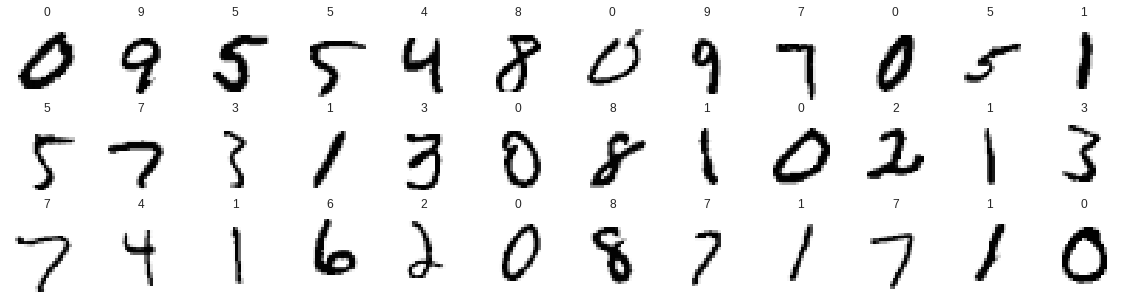

In [6]:
#plotting the dataset
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title((np.where(y_train[i] == 1))[0][0])

In [7]:
#the model architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5, strides = 1,padding='valid',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters=32,kernel_size=5, strides = 1,padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=5, strides = 1,padding='same',activation='relu'))
model.add(Conv2D(filters=64, kernel_size=5, strides = 1,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
#model compilation and adding checkpoint
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint   
checkpointer = ModelCheckpoint(filepath=path_dir+'model.weights.best.hdf5', verbose=1, save_best_only=True)

In [0]:
#image augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)

In [10]:
#training the model
epochs = 30
batch = 200
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch),
                    steps_per_epoch=x_train.shape[0] / batch, epochs=epochs,
                   validation_data=(x_valid, y_valid)
                    ,validation_steps=x_valid.shape[0], 
          callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
143/142 [==============================] - 11s 76ms/step - loss: 1.4058 - acc: 0.6390 - val_loss: 0.3089 - val_acc: 0.9090

Epoch 00001: val_loss improved from inf to 0.30886, saving model to /content/file/My Drive/Colab Notebooks/kaggle/mnist/digit-recognizer/model.weights.best.hdf5
Epoch 2/30
143/142 [==============================] - 8s 57ms/step - loss: 0.2462 - acc: 0.9240 - val_loss: 0.1360 - val_acc: 0.9601

Epoch 00002: val_loss improved from 0.30886 to 0.13601, saving model to /content/file/My Drive/Colab Notebooks/kaggle/mnist/digit-recognizer/model.weights.best.hdf5
Epoch 3/30
143/142 [==============================] - 9s 60ms/step - loss: 0.1637 - acc: 0.9485 - val_loss: 0.0713 - val_acc: 0.9804

Epoch 00003: val_loss improved from 0.13601 to 0.07126, saving model to /content/file/My Drive/Colab Notebooks/kaggle/mnist/digit-recognizer/model.weights.best.hdf5
Epoch 4/30
143/142 [==============================] - 8s 5

In [11]:
#load best weights and predict
model.load_weights(path_dir+'model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9907936507936508


L : Given Label, P : Predicted Label


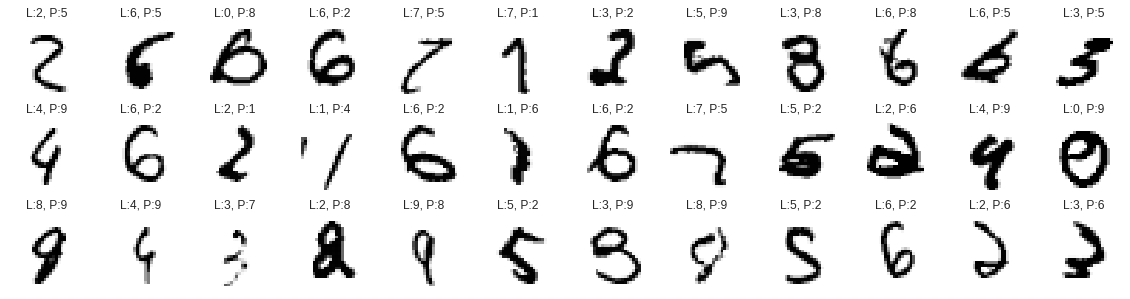

In [12]:
#plotting the wrong classified points
pred = model.predict_classes(x_test)
res = pred==y_test.argmax(1)
wrong_index = np.where(res == 0)[0]

print('L : Given Label, P : Predicted Label')
fig = plt.figure(figsize=(20,5))
for i in range(36):
    j = wrong_index[i]
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[j]))
    ax.set_title('L:{}, P:{}'.format(np.where(y_test[j] == 1)[0][0],pred[j]))

In [0]:
#load the test data
sub_data = pd.read_csv(path_dir+'test.csv')
sub_data = sub_data.values.reshape(sub_data.shape[0],28,28,1)

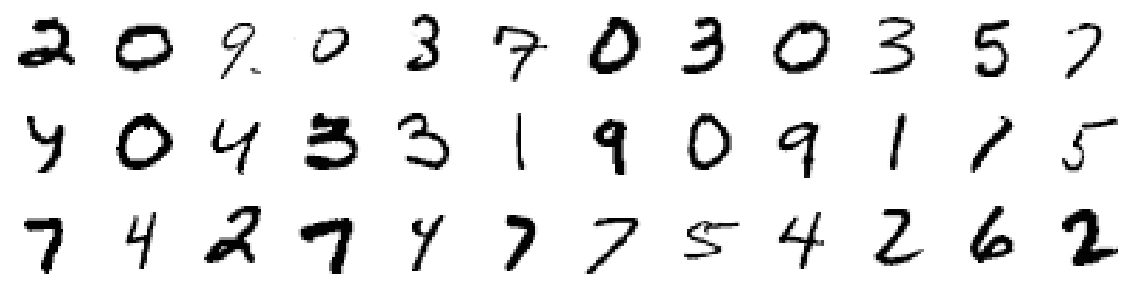

In [14]:
#plot the test data
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(sub_data[i]))

In [0]:
#predict for the test dataset
pred = model.predict_classes(sub_data)

In [0]:
#generate the final prediction file
l = []
for i in range(len(pred)):
    f = {}
    f['ImageId'] = i+1
    f['Label'] = pred[i]
    l.append(f)
pd.DataFrame(l).to_csv(path_dir+'prediction.csv',index = False)